In [1]:
using Revise

In [2]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaOH_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
  ** incremental compilation may be fatally broken for this module **



In [150]:

function make_problem_with_param_constant_diffusion(molecule_package, package_A, param; randomize_initial_vector = true, ψ0=nothing)       
    Γ = molecule_package.Γ
    k = molecule_package.k
    m = molecule_package.m
    ħ = 1.0545718176461565e-34
    λ = 2π/k 

    t_start = param.t_start
    t_end = param.t_end
    pol1_x, pol2_x, pol3_x, pol4_x = param.pol1_x, param.pol2_x, param.pol3_x, param.pol4_x

    s1, s2, s3, s4 = param.s1, param.s2, param.s3, param.s4
    s_ramp_time = param.s_ramp_time * Γ
    s_ramp_factor = param.s_ramp_to_factor
    
    Δ1, Δ2, Δ3, Δ4 = param.Δ1, param.Δ2, param.Δ3, param.Δ4
    B_gradient = param.B_gradient
    temp = param.temp
    diameter = param.diameter
    B_ramp_time = param.B_ramp_time * Γ
    displacement = param.displacement
    kick = param.kick
    
    imbalance = param.pol_imbalance 
    sx_imbalance, sy_imbalance, sz_imbalance = param.s_imbalance[1], param.s_imbalance[2], param.s_imbalance[3] 
    x_center_y, x_center_z, y_center_x, y_center_z, z_center_x, z_center_y = param.off_center .* k
    retro_loss = param.retro_loss
    
    #x_center_y *= rand()
    #x_center_z *= rand()
    #y_center_x *= rand()
    #y_center_z *= rand()
    #z_center_x *= rand()
    #z_center_y *= rand()
    
    dark_lifetime = param.dark_lifetime
    FC_mainline = param.FC_mainline
    
    x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement[1], kick[1],m)
    y_dist, vy_dist = init_MOT_distribution(temp, diameter, displacement[2], kick[2],m)
    z_dist, vz_dist = init_MOT_distribution(temp, diameter, displacement[3], kick[3],m)
  
    states = molecule_package.states
    n_excited = molecule_package.n_excited
    d = molecule_package.d
    Zeeman_x_mat = molecule_package.Zeeman_x_mat
    Zeeman_y_mat = molecule_package.Zeeman_y_mat
    Zeeman_z_mat = molecule_package.Zeeman_z_mat
    
    kx = x̂ + [0, param.pointing_error[1],param.pointing_error[2]]
    kx = kx ./ sqrt(kx[1]^2 + kx[2]^2 + kx[3]^2)
    ky = ŷ + [param.pointing_error[3],0.0,param.pointing_error[4]]
    ky = ky ./ sqrt(ky[1]^2 + ky[2]^2 + ky[3]^2)
    kz = ẑ + [param.pointing_error[5],param.pointing_error[6],0.0]
    kz = kz / sqrt(kz[1]^2 + kz[2]^2 + kz[3]^2)
    
    ODT_intensity = param.ODT_intensity # 13.3*1e3/(50e-4)^2
    ODT_size = param.ODT_size # (30e-6, 2e-3, 30e-6)

    α = param.ODT_revolutions
    r_max = param.ODT_rmax * 1.1
    t_max = param.ODT_tmax * 1.1

    n = 1000
    arclengths = zeros(n)
    # spiral: r = τ; theta = 2πα * τ
    τs = LinRange(0,1.1,n)
    dτ = τs[2]-τs[1]
    length_curr = 0.0

    for i in 1:n
        r = r_max/1 * τs[i]
        θ = 2*π * α * τs[i]
        length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
        arclengths[i] = length_curr
    end

    velocity = length_curr / t_max
    ts = arclengths / velocity
    
   photon_budget = param.photon_budget

    
    n_states = length(states)
    particle = OpticalBlochEquations.Particle()
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    H₀ = zeros(ComplexF64, n_states, n_states)
    
    extra_data = MutableNamedTuple(
        Zeeman_Hx=Zeeman_x_mat,
        Zeeman_Hy=Zeeman_y_mat,
        Zeeman_Hz=Zeeman_z_mat,
        H_ODT_static = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        H_ODT = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        ODT_position = [0.0, 0.0]
        
    )
    
    sim_params = MutableNamedTuple(
        B_gradient = param.B_gradient,
        B_offset = (param.Bx_offset,param.By_offset,param.Bz_offset),
        n_excited = n_excited,
        B_ramp_time = B_ramp_time,
        photon_budget = rand(Exponential(photon_budget)),
        ODT_size = ODT_size,
        dark_lifetime = param.dark_lifetime,
        FC_mainline = param.FC_mainline,

        ODT_rmax = param.ODT_rmax,
        ODT_tmax = param.ODT_tmax,
        ODT_revolutions = param.ODT_revolutions,
        ODT_motion_t_start = param.ODT_motion_t_start,
        ODT_motion_t_stop = param.ODT_motion_t_stop,
        interpolation_times = ts, interpolation_τs = τs,
        
        s_total = s1 + s2 + s3 + s4,
        diffusion_constant = param.diffusion_constant
        )

    t_span = (t_start, t_end) ./ (1/Γ);
    
    ω1 = 2π * (states[end].E - states[1].E) + Δ1
    ω2 = 2π * (states[end].E - states[1].E)  + Δ2
    ω3 = 2π * (states[end].E - states[5].E)  + Δ3
    ω4 = 2π * (states[end].E - states[5].E)  + Δ4

    ϵ_(ϵ, f) = t -> ϵ
    s_func(s) = (x,t) -> s
    s_gaussian(s, axes, centers) = (r,t) -> s * gaussian_intensity_along_axes(r, axes, centers,k)
    
    s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> ((s*factor-s)/ramp_time * min(t, ramp_time) + s) * gaussian_intensity_along_axes(r, axes, centers,k)
    
    
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/500) .* ϵ
    
    rand1 = rand()
    pol1_x = pol1_x.*sqrt(1 - imbalance) + flip(pol1_x).*sqrt(imbalance)*exp(im*2π*rand1)
    rand2 = rand()
    pol2_x = pol2_x.*sqrt(1 - imbalance) + flip(pol2_x).*sqrt(imbalance)*exp(im*2π*rand2)
    rand3 = rand()
    pol3_x = pol3_x.*sqrt(1 - imbalance)  + flip(pol3_x).*sqrt(imbalance)*exp(im*2π*rand3)
    rand4 = rand()
    pol4_x = pol4_x.*sqrt(1 - imbalance) + flip(pol4_x).*sqrt(imbalance)*exp(im*2π*rand4)
    
    sx_rand = 1/2-rand()
    sy_rand = 1/2-rand()
    sz_rand = 1/2-rand()
    
    ϕs = [exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand())]
    s1x = s1 * (1+sx_imbalance*sx_rand)
    s1y = s1 * (1+sy_imbalance*sy_rand)
    s1z = s1 * (1+sz_imbalance*sz_rand)
    k̂ = kx; ϵ1 = ϕs[1]*rotate_pol(pol1_x, k̂); ϵ_func1 = ϵ_(ϵ1, 1); laser1 = Field(k̂, ϵ_func1, ω1,  s_gaussian_ramp(s1x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ2 = ϕs[2]*rotate_pol(pol1_x, k̂); ϵ_func2 = ϵ_(ϵ2, 2); laser2 = Field(k̂, ϵ_func2, ω1, s_gaussian_ramp(s1x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = ky; ϵ3 = ϕs[3]*rotate_pol(pol1_x, k̂); ϵ_func3 = ϵ_(ϵ3, 3); laser3 = Field(k̂, ϵ_func3, ω1,  s_gaussian_ramp(s1y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ4 = ϕs[4]*rotate_pol(pol1_x, k̂); ϵ_func4 = ϵ_(ϵ4, 4); laser4 = Field(k̂, ϵ_func4, ω1,  s_gaussian_ramp(s1y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ5 = ϕs[5]*rotate_pol(flip(pol1_x), k̂); ϵ_func5 = ϵ_(ϵ5, 5); laser5 = Field(k̂, ϵ_func5, ω1,  s_gaussian_ramp(s1z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ6 = ϕs[6]*rotate_pol(flip(pol1_x), k̂); ϵ_func6 = ϵ_(ϵ6, 6); laser6 = Field(k̂, ϵ_func6, ω1, s_gaussian_ramp(s1z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    s2x = s2 * (1+sx_imbalance*sx_rand)
    s2y = s2 * (1+sy_imbalance*sy_rand)
    s2z = s2 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ7 = ϕs[1]*rotate_pol(pol2_x, k̂); ϵ_func7 = ϵ_(ϵ7, 1); laser7 = Field(k̂, ϵ_func7, ω2, s_gaussian_ramp(s2x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ8 = ϕs[2]*rotate_pol(pol2_x, k̂); ϵ_func8 = ϵ_(ϵ8, 2); laser8 = Field(k̂, ϵ_func8, ω2, s_gaussian_ramp(s2x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ9 = ϕs[3]*rotate_pol(pol2_x, k̂); ϵ_func9 = ϵ_(ϵ9, 3); laser9 = Field(k̂, ϵ_func9, ω2, s_gaussian_ramp(s2y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ10 = ϕs[4]*rotate_pol(pol2_x, k̂); ϵ_func10 = ϵ_(ϵ10, 4); laser10 = Field(k̂, ϵ_func10, ω2, s_gaussian_ramp(s2y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ11 = ϕs[5]*rotate_pol(flip(pol2_x), k̂); ϵ_func11 = ϵ_(ϵ11, 5); laser11 = Field(k̂, ϵ_func11, ω2, s_gaussian_ramp(s2z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ12 = ϕs[6]*rotate_pol(flip(pol2_x), k̂); ϵ_func12 = ϵ_(ϵ12, 6); laser12 = Field(k̂, ϵ_func12, ω2, s_gaussian_ramp(s2z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    s3x = s3 * (1+sx_imbalance*sx_rand)
    s3y = s3 * (1+sy_imbalance*sy_rand)
    s3z = s3 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ13 = ϕs[1]*rotate_pol(pol3_x, k̂); ϵ_func13 = ϵ_(ϵ13, 1); laser13 = Field(k̂, ϵ_func13, ω3, s_gaussian_ramp(s3x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ14 = ϕs[2]*rotate_pol(pol3_x, k̂); ϵ_func14 = ϵ_(ϵ14, 2); laser14 = Field(k̂, ϵ_func14, ω3, s_gaussian_ramp(s3x*(1-retro_loss),s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ15 = ϕs[3]*rotate_pol(pol3_x, k̂); ϵ_func15 = ϵ_(ϵ15, 3); laser15 = Field(k̂, ϵ_func15, ω3, s_gaussian_ramp(s3y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ16 = ϕs[4]*rotate_pol(pol3_x, k̂); ϵ_func16 = ϵ_(ϵ16, 4); laser16 = Field(k̂, ϵ_func16, ω3, s_gaussian_ramp(s3y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ17 = ϕs[5]*rotate_pol(flip(pol3_x), k̂); ϵ_func17 = ϵ_(ϵ17, 5); laser17 = Field(k̂, ϵ_func17, ω3, s_gaussian_ramp(s3z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ18 = ϕs[6]*rotate_pol(flip(pol3_x), k̂); ϵ_func18 = ϵ_(ϵ18, 6); laser18 = Field(k̂, ϵ_func18, ω3, s_gaussian_ramp(s3z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    s4x = s4 * (1+sx_imbalance*sx_rand)
    s4y = s4 * (1+sy_imbalance*sy_rand)
    s4z = s4 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ19 = ϕs[1]*rotate_pol(pol4_x, k̂); ϵ_func19 = ϵ_(ϵ19, 1); laser19 = Field(k̂, ϵ_func19, ω4,s_gaussian_ramp(s4x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ20 = ϕs[2]*rotate_pol(pol4_x, k̂); ϵ_func20 = ϵ_(ϵ20, 2); laser20 = Field(k̂, ϵ_func20, ω4, s_gaussian_ramp(s4x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ21 = ϕs[3]*rotate_pol(pol4_x, k̂); ϵ_func21 = ϵ_(ϵ21, 3); laser21 = Field(k̂, ϵ_func21, ω4, s_gaussian_ramp(s4y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ22 = ϕs[4]*rotate_pol(pol4_x, k̂); ϵ_func22 = ϵ_(ϵ22, 4); laser22 = Field(k̂, ϵ_func22, ω4, s_gaussian_ramp(s4y*(1-retro_loss),s_ramp_factor, s_ramp_time,   (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ23 = ϕs[5]*rotate_pol(flip(pol4_x), k̂); ϵ_func23 = ϵ_(ϵ23, 5); laser23 = Field(k̂, ϵ_func23, ω4, s_gaussian_ramp(s4z,s_ramp_factor, s_ramp_time,   (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ24 = ϕs[6]*rotate_pol(flip(pol4_x), k̂); ϵ_func24 = ϵ_(ϵ24, 6); laser24 = Field(k̂, ϵ_func24, ω4, s_gaussian_ramp(s4z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    lasers = [lasers_1;lasers_2; lasers_3; lasers_4]
        
    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)
    if randomize_initial_vector
        randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        random_initial_state!(prob.p)
     else
        prob.p.ψ .= ψ0
     end
               
    return prob
end

make_problem_with_param_constant_diffusion (generic function with 1 method)

In [219]:

function get_toy_package()
    λ = 626e-9
    Γ = 2π* 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    
    QN_bounds = (
        S = 1/2, 
        I = 1/2, 
        Λ = 0, 
        N = 0:3
    )
    X_state_basis = enumerate_states(HundsCaseB_Rot, QN_bounds)

    X_state_operator = :(
        BX * Rotation + 
        DX * RotationDistortion + 
        γX * SpinRotation + 
        bFX * Hyperfine_IS + 
        cX * (Hyperfine_Dipolar/3)
    )

    X_state_parameters = QuantumStates.@params begin
        BX = 10023.0841
        DX = 1.154e-2
        γX = 34.7593
        bFX = 2.602
        cX = 2.053
    end

    X_state_ham = Hamiltonian(basis=X_state_basis, operator=X_state_operator, parameters=X_state_parameters)

    # Add Zeeman terms
   
    X_state_ham = add_to_H(X_state_ham, :B_x, (gS * _μB * 1e-6) * Zeeman_x)
    X_state_ham = add_to_H(X_state_ham, :B_y, (gS * _μB * 1e-6) * Zeeman_y)
    X_state_ham = add_to_H(X_state_ham, :B_z, (gS * _μB * 1e-6) * Zeeman_z)
    X_state_ham.parameters.B_x = 0.
    X_state_ham.parameters.B_y = 0.
    X_state_ham.parameters.B_z = 0.

    evaluate!(X_state_ham)
    QuantumStates.solve!(X_state_ham)
    ;

    QN_bounds = (
        S = 1/2,
        I = 1/2,
        Λ = (-1,1),
        J = 1/2:5/2
    )
    A_state_basis = enumerate_states(HundsCaseA_Rot, QN_bounds)

    A_state_operator = :(
        T_A * DiagonalOperator +
        Be_A * Rotation + 
        Aso_A * SpinOrbit +
        q_A * ΛDoubling_q +
        p_A * ΛDoubling_p2q + q_A * (2ΛDoubling_p2q)
    )

    # Spectroscopic constants for CaOH, A state
    A_state_parameters = QuantumStates.@params begin
        T_A = 15998.122 * 299792458 * 1e-4
        Be_A = 0.3412200 * 299792458 * 1e-4
        Aso_A = 66.8181 * 299792458 * 1e-4
        p_A = -0.04287 * 299792458 * 1e-4
        q_A = -0.3257e-3 * 299792458 * 1e-4
    end

    A_state_ham = Hamiltonian(basis=A_state_basis, operator=A_state_operator, parameters=A_state_parameters)
    evaluate!(A_state_ham)
    QuantumStates.solve!(A_state_ham)
    ;

    A_state_J12_pos_parity_states = A_state_ham.states[5:8]

    QN_bounds = (
        S = 1/2, 
        I = 1/2, 
        Λ = (-1,1), 
        N = 0:3
    )
    A_state_caseB_basis = enumerate_states(HundsCaseB_Rot, QN_bounds)

    ground_states = [X_state_ham.states[5:8]; X_state_ham.states[9:16]]
    excited_states = convert_basis(A_state_J12_pos_parity_states, A_state_caseB_basis)[1:end]

    states = [ground_states; excited_states]
    n_excited = length(excited_states)
    n_states = length(states)

    for state ∈ states
        state.E *= 1e6
    end
    ;

    d = zeros(ComplexF64, n_states, n_states, 3)
    d_ge = zeros(ComplexF64, n_states - n_excited, n_excited, 3)

    basis_tdms = get_tdms_two_bases(X_state_ham.basis, A_state_caseB_basis, TDM)
    tdms_between_states!(d_ge, basis_tdms, ground_states, excited_states)
    d[1:n_states - n_excited, n_states-n_excited + 1:n_states, :] .= d_ge
    
#     Zeeman_x(state, state′) = (Zeeman(state, state′,-1) - Zeeman(state, state′,1))/sqrt(2)
#     Zeeman_y(state, state′) = im*(Zeeman(state, state′,-1) + Zeeman(state, state′,1))/sqrt(2)
#     Zeeman_z(state, state′) = Zeeman(state, state′, 0)

    Zeeman_x_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_x, ground_states, excited_states) .* (2π*gS*_μB/Γ))
    Zeeman_y_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_y, ground_states, excited_states) .* (2π*gS*_μB/Γ))
    Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, ground_states, excited_states) .* (2π*gS*_μB/Γ))
                

    package = MutableNamedTuple(states=states, n_excited=n_excited, d=d, Zeeman_x_mat=Zeeman_x_mat, Zeeman_y_mat=Zeeman_y_mat, Zeeman_z_mat=Zeeman_z_mat, Γ = Γ , k = k, m = m)
    return package
end;


## Define CaOH Hamiltonian and molecular states

In [220]:
package = get_toy_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = get_toy_package(); # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m;

In [221]:
energy.(package.states) .- energy(package.states[1])

16-element Vector{Float64}:
    0.0
 7485.536777496338
 7485.536777496338
 7485.536777496338
    5.1240297796562195e7
    5.1240297796569824e7
    5.1240297796569824e7
    5.275484747470474e7
    5.275484747470474e7
    5.275484747470856e7
    5.275484747470856e7
    5.275484747470856e7
    4.7860092421321244e14
    4.7860092421321244e14
    4.7860092421321244e14
    4.7860092421321244e14

## Define experimental parameters

In [222]:
## Initial condition of the molecule cloud
temp = @with_unit 100e-3 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = 75; ramp_time = 4e-3


Δ1 = 1.2Γ
Δ3 = 0.8Γ 
Δ4 = 1.07Γ 

s_total = (1.5 + 1.12 + 1.4) 

s1 = 1.5
s3 = 1
s4 = 1.4 * 0 

s_total1 = s1+s3+s4
s1 = s1 * s_total/s_total1
s3 = s3 * s_total/s_total1
s4 = s4 * s_total/s_total1

blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 20,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2,

                                diffusion_constant =0)
;

remove F=0 in J=1/2 => 3 good, 2(pm) good

remove F=1 in J=1/2 => 3 bad

remove F=2 in J=3/2 => 3 bad-ish

remove F=1 in J=3/2 => 3 bad

remove F=0 in A => 3 good, 2(pm) bad-ish, 2(pp) bad

remove F=1 in A => 3 bad, 2(pm) bad, 2(pp) bad

remove F=0 in J1/2 and A => 3 good, 2 bad

## Find the diffusion constant

In [223]:
# diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=1e-4, n_particles=20, 
#                                             ramp_time=1e-6, temp = 1e-4, diameter=80e-6)
# @printf("Diffusion constant = %.2f \n", diffusion_constant)

# blue_MOT_params.diffusion_constant = diffusion_constant;

sequence = [blue_MOT_params]
durations = [10e-3]
generate_sequence!(sequence, durations);
@time results = simulate_particles_constant_diffusion(package, package_A, sequence);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.188838 seconds (35.22 k allocations: 7.408 MiB)


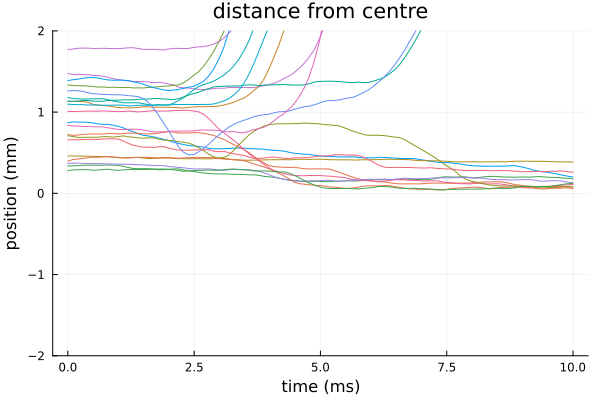

In [224]:
plot_all_trajectories(results, "all")
plot!(ylim=[-2,2])

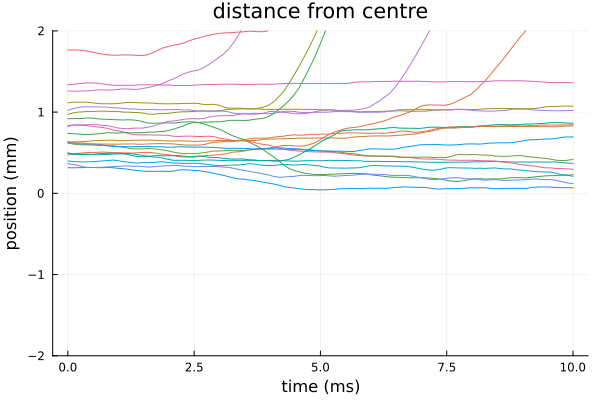

In [218]:
plot_all_trajectories(results, "all")
plot!(ylim=[-2,2])

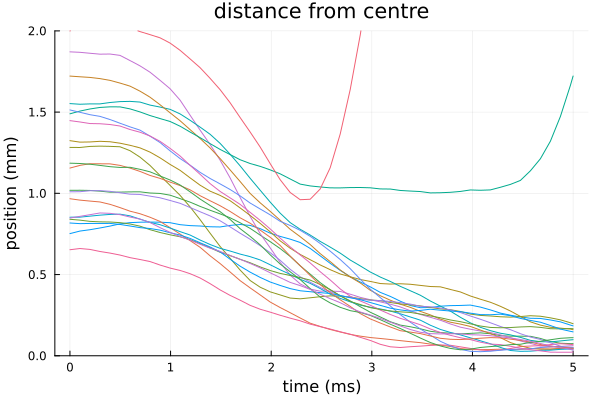

In [172]:
plot_all_trajectories(results, "all")
plot!(ylim=[-0,2])

In [112]:
bootstrap_size_fit(results,5;iter=100)

(0.07064881165152422, 6.973850769498386e-17)

Final size = 0.176 mm

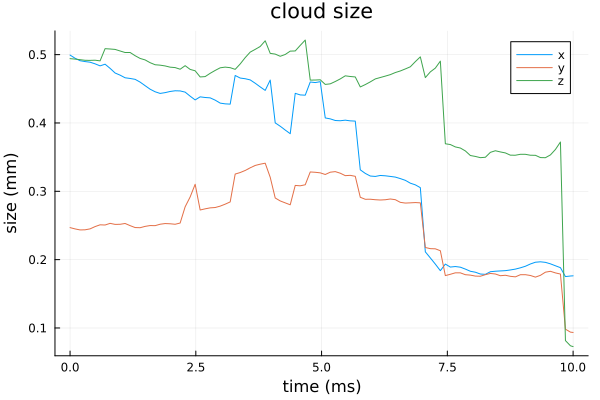

In [169]:
~, σ = plot_size(results,"all")
@printf("Final size = %.3f mm", σ[end])
plot!()

Temperature = 241.9 uK

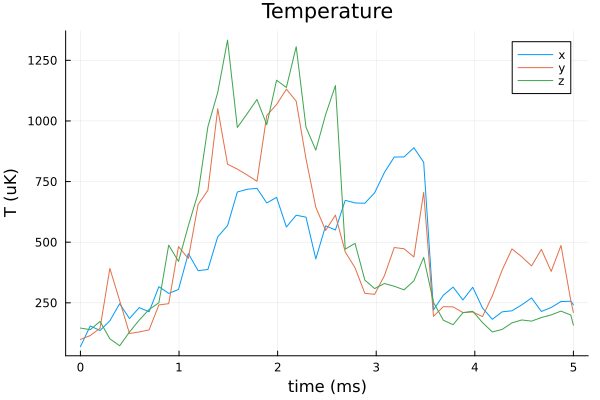

In [26]:
~, T = plot_temperature(results, "all")
@printf("Temperature = %.1f uK", T[end])
plot!()

Average scattering rate = 1.13 MHz

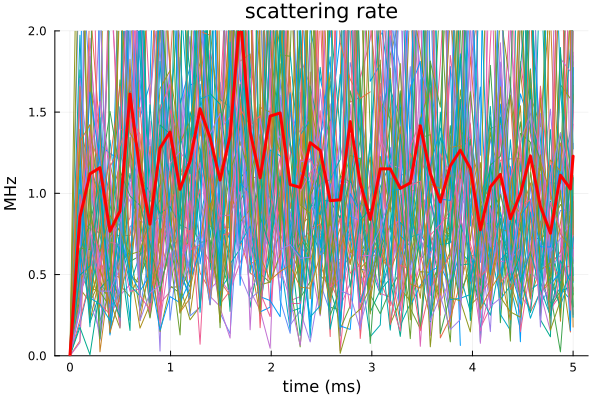

In [27]:
sr = plot_scattering_rate(results)
@printf("Average scattering rate = %.2f MHz", sr)
plot!(ylim=[0,2])

### Simulate camera images
We can also generate "camera images" by taking 2D snapshots (integrated over y direction) of the molecules.

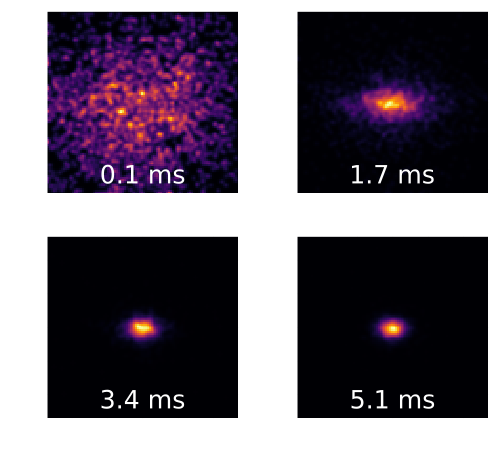

In [32]:
ROI = 0.8  # mm

img_duration = 2.0   # the image will be averaged over this duration
n_pixels = 100

ts = [0.1,1.7,3.4,5.1]
filter = 1.   # Gaussian filtering the image

plots = []
for t in ts
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=0.0, photon_budget=12000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    p = heatmap(x,z,imgg',legend=:none, xaxis=false, yaxis=false)
    annotate!(0,-ROI*0.8,text(@sprintf("%.1f ms", t),:white,17))
    push!(plots, p)
end

plot(plots[1],plots[2],plots[3],plots[4], size=(500,450))
    
plot!()